In [11]:
import time
import mujoco
import mujoco.viewer
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
import copy
import os

In [ ]:
#mesh paths:
cwd = os.path.dirname(os.getcwd())
path_guard = os.path.join(cwd,r"Meshes\Simulation\headGuard.stl")
path_platform = os.path.join(cwd,r"Meshes\Simulation\platform_1percent_size.stl")
print(cwd)
print(path_guard)
print(path_platform)

In [13]:
def rotate_offset_vector(vector, angle_degrees,side_offset):
    angle_radians = np.radians(angle_degrees)
    vector = vector + side_offset
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])
    rotated_vector = np.dot(rotation_matrix, vector)
    
    return rotated_vector

def angle_between_vectors(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    cosine_angle = dot_product / magnitude_product
    angle_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

In [14]:
#Parameters 
#rod info
full_size = 1
r1_len_extension = full_size/2
r1_pos = r1_len_extension

r2_len_extension = full_size/2
r2_pos = r2_len_extension

r1_len = .2+ r1_len_extension
r2_len = .2+ r2_len_extension

rod_radius =  0.05

#body positions:
rx1_z = 0.3 
rx2_z = 0.2 + r1_len_extension*2
anc_z = 0.3 + r2_len_extension*2

#rod range
s_range_low = -0.5
s_range_high = 0

rodx1_pos = 0
rodx2_pos = f"{rx2_z - r2_len}"

head_z = 1.5


#relational position
rel_pos_z = -(head_z+rx1_z+rx2_z +anc_z)

side_offset = np.array([0,0.08]) #offset sideways from 120 deg angle direction
side_length = 1.4

dir_a23 = side_length*np.array([1,0])
vec_a2 = rotate_offset_vector(dir_a23,0,side_offset)
vec_a3 = rotate_offset_vector(dir_a23,0,-side_offset)

vec_a4 = rotate_offset_vector(dir_a23,-120,side_offset)
vec_a5 = rotate_offset_vector(dir_a23,-120,-side_offset)

vec_a6 = rotate_offset_vector(dir_a23,-240,side_offset)
vec_a1 = rotate_offset_vector(dir_a23,-240,-side_offset)


a2_pos = f"{vec_a2[0]} {vec_a2[1]} {rel_pos_z} 1 0 0 0" 
a3_pos = f"{vec_a3[0]} {vec_a3[1]}  {rel_pos_z} 1 0 0 0"

a4_pos = f"{vec_a4[0]} {vec_a4[1]} {rel_pos_z} 1 0 0 0"
a5_pos = f"{vec_a5[0]} {vec_a5[1]} {rel_pos_z} 1 0 0 0"

a6_pos = f"{vec_a6[0]} {vec_a6[1]} {rel_pos_z} 1 0 0 0"
a1_pos = f"{vec_a1[0]} {vec_a1[1]} {rel_pos_z} 1 0 0 0"

#rod attachement to object locations
bot_length = 1
dir_b56 = bot_length*np.array([1,0])
vec_b5 = rotate_offset_vector(dir_b56,0,side_offset)
vec_b6 = rotate_offset_vector(dir_b56,0,-side_offset)

vec_b1 = rotate_offset_vector(dir_b56,-120,side_offset)
vec_b2 = rotate_offset_vector(dir_b56,-120,-side_offset)

vec_b3 = rotate_offset_vector(dir_b56,-240,side_offset)
vec_b4 = rotate_offset_vector(dir_b56,-240,-side_offset)

b1_pos = f"{vec_b1[0]} {vec_b1[1]} {rx1_z}" #
b2_pos = f"{vec_b2[0]} {vec_b2[1]} {rx1_z}" #

b3_pos = f"{vec_b3[0]} {vec_b3[1]} {rx1_z}"
b4_pos = f"{vec_b4[0]} {vec_b4[1]} {rx1_z}"

b5_pos = f"{vec_b5[0]} {vec_b5[1]} {rx1_z}"
b6_pos = f"{vec_b6[0]} {vec_b6[1]} {rx1_z}"

#motor power/dampening
rod_damp = 1
spring_rest = 0
rod_stiff = 1
weld_damp = 10000
motor_power = 10000


#measurements
print(vec_a1,rel_pos_z)
print(vec_a2,rel_pos_z)
print(vec_a3,rel_pos_z)
print(vec_a4,rel_pos_z)
print(vec_a5,rel_pos_z)
print(vec_a6,rel_pos_z)

print(vec_b1,rx1_z)
print(vec_b2,rx1_z)
print(vec_b3,rx1_z)
print(vec_b4,rx1_z)
print(vec_b5,rx1_z)
print(vec_b6,rx1_z)

print("distance between bottom:", np.linalg.norm(vec_b1-vec_b6), "distance between top:", np.linalg.norm(vec_a1 - vec_a2))
print("angle between top:" , angle_between_vectors(vec_b1,vec_b5), "angle between bottom:", angle_between_vectors(vec_a1,vec_a3))

[-0.63071797  1.25243557] -4.3
[1.4  0.08] -4.3
[ 1.4  -0.08] -4.3
[-0.63071797 -1.25243557] -4.3
[-0.76928203 -1.17243557] -4.3
[-0.76928203  1.17243557] -4.3
[-0.43071797 -0.9060254 ] 0.3
[-0.56928203 -0.8260254 ] 0.3
[-0.56928203  0.8260254 ] 0.3
[-0.43071797  0.9060254 ] 0.3
[1.   0.08] 0.3
[ 1.   -0.08] 0.3
distance between bottom: 1.652050807568877 distance between top: 2.3448711305964287
angle between top: 119.99999999999999 angle between bottom: 120.00000000000004


In [15]:
xml = f"""
<mujoco>
  <asset>
    <!-- WORLD -->
    <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512" />
    <texture name="plane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8" />
    <material name="plane" reflectance="0.3" texture="plane" texrepeat="1 1" texuniform="true" />

    <!-- MESHES -->
    <mesh name="guard" file="{path_guard}"/>
    <mesh name="ywing" file="{path_platform}"/>
  </asset>


  <option>
    <flag contact="disable"/>
    <!--flag gravity="disable"/-->
    <!--flag contact="disable" gravity="disable"/-->
  </option>
  <!--option  gravity="0 0 1"/-->


  <worldbody>
    <light directional="true" diffuse=".2 .2 .2" specular="0 0 0" pos="0 1 5" dir="0 -1 -1" castshadow="false"/>
    <light directional="false" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -1 4" dir="0 0 -1" />
    <light directional="true" diffuse="0 0 0" specular=".7 .7 .7" pos="0 3 3" dir="0 -3 -3" />
    <geom name="floor" pos="0 0 0" group="1" size="0 0 .1" type="plane" material="plane" condim="3" />
    <camera name="fixed" pos="0.113 -4.286 5.167" xyaxes="1.000 0.003 0.000 -0.002 0.678 0.735"/>

    
    <body name="top" pos="0 0 {-rel_pos_z}" euler="0 180 0">
      <!--geom name="red_box_mesh_top" type="mesh" mesh="ywing"/-->
      <geom name="red_circle_top" type="cylinder" size="{side_length} .2" rgba="1 0 0 0.3"/>
    </body>

    <body name="head" pos="0 0 {head_z}" euler="0 0 0">
        <joint name="freehead" type="free"/>
        <!--geom name="red_box" type="box" size="1 1 .2" rgba="1 0 0 1"/--> !--add mass here if neeeded --
        <geom name="red_box" type="cylinder" size="1 .2" rgba="1 0 0 1"/>
        <geom name="red_box_mesh" type="mesh" mesh="ywing"/>

        <body name="rod11" pos="{b1_pos}"> !-- change atatchment point to box -- 
              <joint name="ball11" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod11" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod12" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide1" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod12" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor1" pos="0 0 {anc_z}">
                    <joint name="ball12" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor1" type="box" size=".1 .1 .1" rgba="0 0 1 1"/>
                </body>
              </body>
        </body>

        <body name="rod21" pos="{b2_pos}"> !-- change atatchment point to box --
              <joint name="ball21" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod21" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod22" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide2" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod22" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor2" pos="0 0 {anc_z}">
                    <joint name="ball22" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor2" type="box" size=".1 .1 .1" rgba="0 0 1 1"/>
                </body>
              </body>
        </body>

        <body name="rod31" pos="{b3_pos}"> !-- change atatchment point to box -- 
              <joint name="ball31" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod31" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod32" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide3" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod32" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor3" pos="0 0 {anc_z}">
                    <joint name="ball32" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor3" type="box" size=".1 .1 .1" rgba="0 1 1 1"/>
                </body>
              </body>
        </body>

        <body name="rod41" pos="{b4_pos}"> !-- change atatchment point to box --
              <joint name="ball41" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod41" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod42" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide4" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod42" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor4" pos="0 0 {anc_z}">
                    <joint name="ball42" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor4" type="box" size=".1 .1 .1" rgba="0 1 1 1"/>
                </body>
              </body>
        </body>

        <body name="rod51" pos="{b5_pos}"> !-- change atatchment point to box -- 
              <joint name="ball51" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod51" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod52" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide5" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod52" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor5" pos="0 0 {anc_z}">
                    <joint name="ball52" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor5" type="box" size=".1 .1 .1" rgba="1 0 1 1"/>
                </body>
              </body>
        </body>

        <body name="rod61" pos="{b6_pos}"> !-- change atatchment point to box --
              <joint name="ball61" type="ball" axis="1 0 0" pos="0 0 -.2"/>
              <geom name="rod61" type="capsule" size=".05 {r1_len}" rgba="1 0 1 0.5" pos="0 0 {r1_pos}"/>

              <body name="rod62" pos="0 0 {rx2_z}" quat="1 0 0 0">
                <joint name="slide6" type="slide" axis="0 0 1" pos="0 0 0" limited="true" range="{s_range_low} {s_range_high}" damping="{rod_damp}" stiffness="{rod_stiff}" springref="{spring_rest}"/>
                <geom name="rod62" type="capsule" size=".05 {r2_len}" rgba="1 1 0 0.5" pos="0 0 {r2_pos}"/>

                <body name="anchor6" pos="0 0 {anc_z}">
                    <joint name="ball62" type="ball" axis="1 0 0" pos="0 0 -.1"/>
                    <geom name="anchor6" type="box" size=".1 .1 .1" rgba="1 0 1 1"/>
                </body>
              </body>
        </body>
    </body>

    <!--
    <body name="guard">
      <geom name="guard" type="mesh" mesh="guard" euler="0 -90 0"/>
    </body>
    -->
  </worldbody>

  <equality>
    !--change relpos to change the position of weld points  repective to the world--
    !-- torquescale="100" -- 

    <weld name = "anchor1" body1="anchor1" relpose="{a1_pos} " torquescale="{weld_damp}"/>
    <weld name = "anchor2" body1="anchor2" relpose="{a2_pos} " torquescale="{weld_damp}"/>

    <weld name = "anchor3" body1="anchor3" relpose="{a3_pos} " torquescale="{weld_damp}"/>
    <weld name = "anchor4" body1="anchor4" relpose="{a4_pos} " torquescale="{weld_damp}"/>

    <weld name = "anchor5" body1="anchor5" relpose="{a5_pos} " torquescale="{weld_damp}"/>
    <weld name = "anchor6" body1="anchor6" relpose="{a6_pos} " torquescale="{weld_damp}"/>
  </equality>


  <actuator>

    <position name="s1" joint="slide1" ctrlrange="-1 0" kp="{motor_power}"/>
    <position name="s2" joint="slide2" ctrlrange="-1 0" kp="{motor_power}"/>
    
    <position name="s3" joint="slide3" ctrlrange="-1 0" kp="{motor_power}"/>
    <position name="s4" joint="slide4" ctrlrange="-1 0" kp="{motor_power}"/>
    
    <position name="s5" joint="slide5" ctrlrange="-1 0" kp="{motor_power}"/>
    <position name="s6" joint="slide6" ctrlrange="-1 0" kp="{motor_power}"/>


  </actuator>

  <sensor>
    <framepos name="box_pos" objtype="geom" objname="red_box"/>
    <framequat name="box_rot" objtype="geom" objname="red_box"/>
  </sensor>

</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
mujoco.mj_kinematics(model,data)
#mujoco.viewer.launch(model)

In [16]:
def plotPos(positions,times):
  xpos = [pos[0] for pos in positions]
  ypos = [pos[1] for pos in positions]
  zpos = [pos[2] for pos in positions]

  plt.title("Positions")
  plt.plot(times,xpos,label="x")
  plt.plot(times,ypos,label="y")
  plt.plot(times,zpos,label="z")
  plt.legend()
  plt.show()

def get_xyz(rotation_list):
  x = [rot[0] for rot in rotation_list]
  y= [rot[1] for rot in rotation_list]
  z = [rot[2] for rot in rotation_list]

  return x,y,z

def quaternion_to_euler(quaternion):
    # Create a rotation object from the quaternion
    r = Rotation.from_quat(quaternion)
    
    # Convert the rotation to Euler angles
    euler_angles = r.as_euler('xyz', degrees=True)
    
    return euler_angles

def plotRots(rots,times):
  rots_reordered = [np.concatenate((rot[1:],np.array([rot[0]]))) for rot in rots]
  euler_angles = [quaternion_to_euler(rot) for rot in rots_reordered]
  xrot,yrot,zrot = get_xyz(euler_angles)

  plt.title("Rotations")
  plt.plot(times,xrot,label="x")
  plt.plot(times,yrot,label="y")
  plt.plot(times,zrot,label="z")
  plt.legend()
  plt.show()

def plotActs(acts,times):
  as1 = [a[0] for a in acts]
  as2 = [a[1] for a in acts]
  as3 = [a[2] for a in acts]
  as4 = [a[3] for a in acts]
  as5 = [a[4] for a in acts]
  as6 = [a[5] for a in acts]

  plt.title("Actuation values")
  plt.plot(times,as1,label="s1")
  plt.plot(times,as2,label="s2")
  plt.plot(times,as3,label="s3")
  plt.plot(times,as4,label="s4")
  plt.plot(times,as5,label="s5")
  plt.plot(times,as6,label="s6")
  plt.legend()
  plt.show()


Time passed: 17.368184328079224
Amount of measurements: 1122


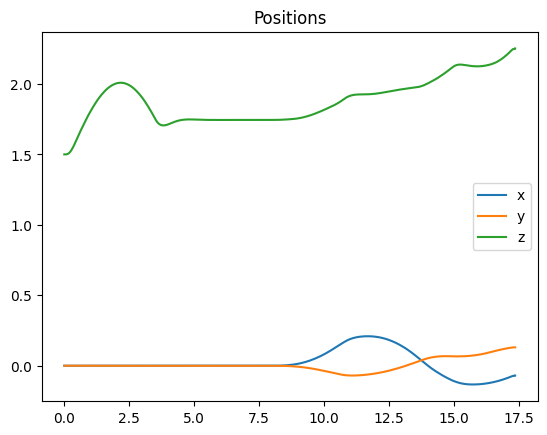

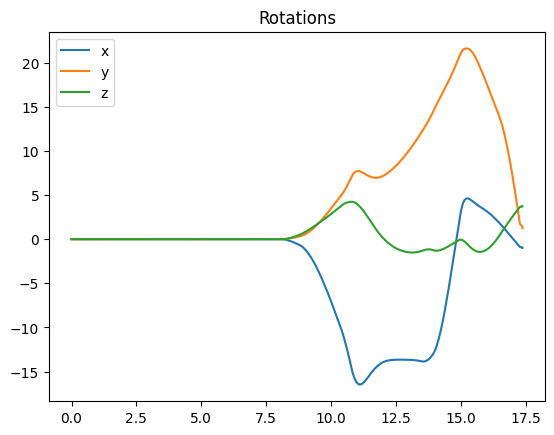

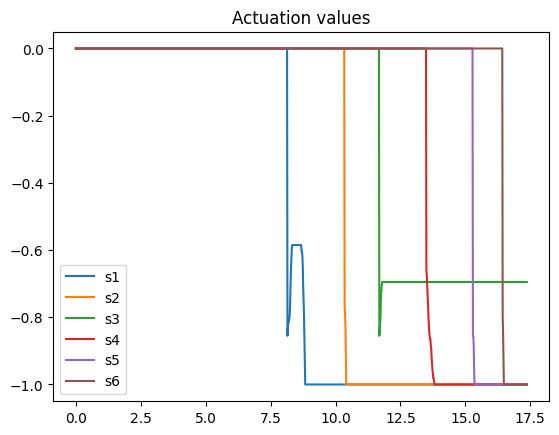

In [17]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

#data logging
poss = []
rots = []
times = []
acts = []

#launch_pasive - if you dont want pausing/run | otherwise just use launch
with mujoco.viewer.launch_passive(model, data) as viewer:
  # Close the viewer automatically after 30 wall-seconds.
  start = time.time()
  while viewer.is_running() and time.time() - start < 3600:
    step_start = time.time()

    # mj_step can be replaced with code that also evaluates
    # a policy and applies a control signal before stepping the physics.
    mujoco.mj_step(model, data)

    # Example modification of a viewer option: toggle contact points every two seconds.
    with viewer.lock():
      viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time % 2)

    #print/log to track stuff
    poss.append(copy.deepcopy(data.sensor("box_pos").data))
    rots.append(copy.deepcopy(data.sensor("box_rot").data))
    times.append(time.time()-start)
    acts.append(copy.deepcopy([data.actuator("s1").ctrl,data.actuator("s2").ctrl,data.actuator("s3").ctrl,data.actuator("s4").ctrl,data.actuator("s5").ctrl,data.actuator("s6").ctrl]))

    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    #print(time_until_next_step,time.time()-start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

print("Time passed:", times[-1])

print("Amount of measurements:", len(times))
plotPos(poss,times)
plotRots(rots,times)
plotActs(acts,times)